In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
import warnings
from sklearn.exceptions import ConvergenceWarning

from sklearn.model_selection import train_test_split

from datasets import load_dataset,Dataset,DatasetDict#, load_metric
import evaluate
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict



import plotly.express as px

from transformers import DataCollatorWithPadding,AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer, AutoModel, AutoConfig


import torch
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from helpers import ClassifierModel, loadTrainTweets, loadModel, normalizeTweets, tokenizeTweets
from helpers import *

In [2]:

import numpy as np
from datasets import load_dataset,Dataset,DatasetDict

from transformers import DataCollatorWithPadding,AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer, AutoModel, AutoConfig
from transformers.modeling_outputs import TokenClassifierOutput, SequenceClassifierOutput
from transformers import AdamW, get_scheduler

from datasets import load_metric

from tqdm.auto import tqdm


import torch
import torch.nn as nn
import pandas as pd
import time

from tqdm import tqdm

from torch.utils.data import  DataLoader

from contextlib import contextmanager
import sys

from sklearn.model_selection import KFold
import os

# Load Tweets

In [3]:
positive_file_path = 'data/train_pos_full.txt'
negative_file_path = 'data/train_neg_full.txt'
positive_file_path_small = 'data/train_pos.txt'
negative_file_path_small = 'data/train_neg.txt'

# Load  (Full and Small datasets)
df = loadTrainTweets(positive_file_path, negative_file_path)
df_small = loadTrainTweets(positive_file_path_small, negative_file_path_small)

# GloVe

# TF-IDF

Hyperparameter search over Lambda (regularization strength, max_df and min_df), small tweet datasets have benn used for faster computation.

In [27]:
# Regularization Strength for logistic regression
lambdas = [1e-3, 1e-2, 1e-1, 1, 10]

# Ignore tokens that have a document frequency strictly higher than 
# max_df (corpus-specific stop words)
max_dfs = [0.5, 0.7, 0.8, 1.0]

# Ignore terms that have a document frequency strictly lower than the given threshold. 
# This value is also called cut-off in the literature
min_dfs = [1, 2, 3, 5]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

# Initialization of accuracy 
acc_best = 0

# Array containing different accuracies, lambdas, max_dfs and min_dfs
results = []

with warnings.catch_warnings():
    for lambda_ in lambdas :
        for max_df in max_dfs :
            for min_df in min_dfs :
                warnings.filterwarnings("ignore", category=ConvergenceWarning)

                print("Lambda : ", lambda_)
                print("max_df : ", max_df)
                print("min_df : ", min_df)

                # Initialoize TF-IDF Encoder
                text_transformer = TfidfVectorizer(stop_words=None, 
                                                    ngram_range=(1,2),
                                                    max_df=max_df,
                                                    min_df= min_df, 
                                                    lowercase=True)
                
                # Encode the dataset using TF-IDF
                X_train_cross = text_transformer.fit_transform(df_small['tweets'])

                # Initialize Logistic Regression model
                logit = LogisticRegression(C = 1/lambda_, solver='lbfgs')

                # Classify the training data using cross-validation
                predicted_labels = cross_val_predict(logit, X_train_cross, df_small['labels'], cv=skf)

                # Compute the accuracy score
                acc = accuracy_score(df_small['labels'], predicted_labels)

                print("Accuracy: ", acc)
                print("--------------------------------------------")

                result = {
                    "Lambda": lambda_,
                    "Accuracy": acc,
                    "max_df": max_df,
                    "min_df": min_df
                }

                if acc > acc_best:
                    acc_best = acc
                    lambda_best = lambda_
                    max_df_best = max_df
                    min_df_best = min_df

                results.append(result)


print("------------------------------------------------------------------------")
print("--------------------------------------------")

print("BEST RESULT: ", "Accuracy : ", acc_best,
                       "lambda: ", lambda_best,
                       "max_df : ", max_df,
                       "min_df", min_df)

results.sort(key=lambda x: x["Accuracy"], reverse=True)

print("Top 10 Results with the Highest Accuracy:")
print("--------------------------------------------")
for i, result in enumerate(results[:10]):
    print(f"Rank {i + 1}:")
    print(f"Accuracy: {result['Accuracy']}")
    print(f"Lambda: {result['Lambda']}")
    print(f"max_df: {result['max_df']}")
    print(f"min_df: {result['min_df']}")
    
    print("--------------------------------------------")

# Save Results into a csv file to save results and avoid performing the 
# hyperparameter search again
dfResults = pd.DataFrame(results)

Lambda :  0.001
max_df :  0.5
min_df :  1
Accuracy:  0.8206517934820652
--------------------------------------------
Lambda :  0.001
max_df :  0.5
min_df :  2
Accuracy:  0.8091669083309166
--------------------------------------------
Lambda :  0.001
max_df :  0.5
min_df :  3
Accuracy:  0.8086469135308647
--------------------------------------------
Lambda :  0.001
max_df :  0.5
min_df :  5
Accuracy:  0.7982120178798212
--------------------------------------------
Lambda :  0.001
max_df :  0.7
min_df :  1
Accuracy:  0.8194918050819492
--------------------------------------------
Lambda :  0.001
max_df :  0.7
min_df :  2
Accuracy:  0.8117018829811702
--------------------------------------------
Lambda :  0.001
max_df :  0.7
min_df :  3
Accuracy:  0.8113218867811322
--------------------------------------------
Lambda :  0.001
max_df :  0.7
min_df :  5
Accuracy:  0.8128068719312807
--------------------------------------------
Lambda :  0.001
max_df :  0.8
min_df :  1
Accuracy:  0.819491805

### Read Results from Hyperparameter search and Set optimal max_df and min_df values

In [5]:
max_dfOpt = 0.5
min_dfOpt = 1

### Plot Accuracy vs Lambda for the optimal max_df value and different min_df values

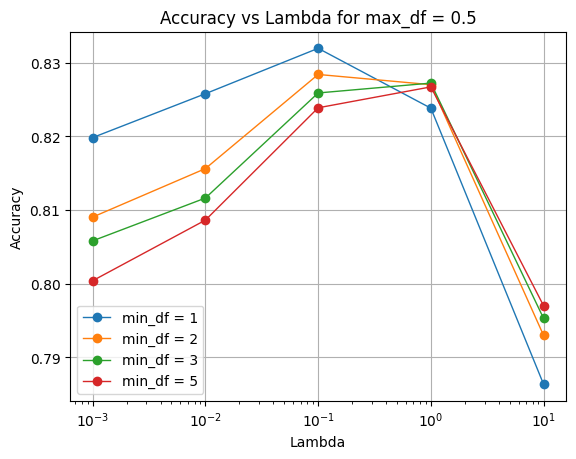

In [6]:
plot_TF_IDF_results(dfResults, max_dfOpt, fixed_param = 'max_df', var_param = 'min_df')

### Plot Accuracy vs Lambda for the optimal min_df value and different max_df values

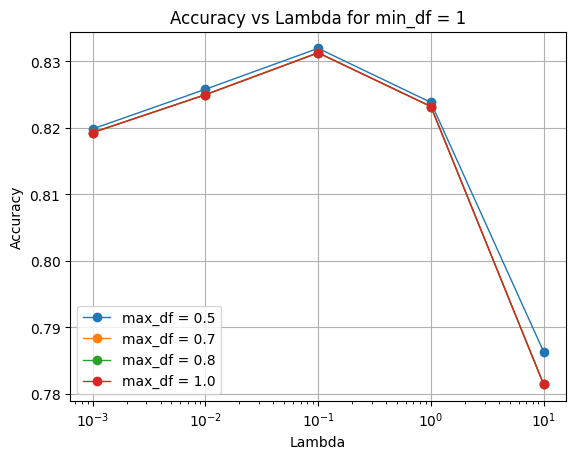

In [7]:
plot_TF_IDF_results(dfResults, min_dfOpt, fixed_param = 'min_df', var_param = 'max_df')

# Transformers

## Learning Rate Hyperparameter Search

In [ ]:
from datasets import load_metric
from transformers import AdamW, get_scheduler
from tqdm.auto import tqdm


checkpoint = 'vinai/bertweet-base'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_classfier = ClassifierModel(checkpoint = checkpoint, num_labels =2).to(device)
mode = 'train'

# Normalize Tweets
df = normalizeTweets(df)

# Tokenize Tweets
train_dataloader, eval_dataloader, test_dataloader = tokenizeTweets(checkpoint,df,mode)

metric = load_metric("accuracy")
Accs = []

# Define the range of logarithmic learning rates you want to search
log_learning_rate_range = [10 **(-6), 10 **(-5), 10 **(-4)]

for log_learning_rate in log_learning_rate_range:
    learning_rate = log_learning_rate
    model_classfier = ClassifierModel(checkpoint = checkpoint, num_labels =2).to(device)

    optimizer_env = AdamW(model_classfier.parameters(), lr=learning_rate)
    num_epochs = 6
    num_training_steps_env = num_epochs * len(train_dataloader)

    lr_scheduler_env = get_scheduler('linear',
                                     optimizer=optimizer_env,
                                     num_warmup_steps=0,
                                     num_training_steps=num_training_steps_env)

    t = str(time.time())[:10]

    progress_bar_train = tqdm(range(num_training_steps_env))
    progress_bar_eval = tqdm(range(num_epochs * len(eval_dataloader)))

    Acc_max = 0

    for epoch in range(num_epochs):

        model_classfier.train()
        for batch in train_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            _, pure_loss = model_classfier(**batch)

            pure_loss.backward()

            optimizer_env.step()
            lr_scheduler_env.step()
            optimizer_env.zero_grad()
            progress_bar_train.update(1)

        model_classfier.eval()
        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs, pure_loss = model_classfier(**batch)

            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            metric.add_batch(predictions=predictions, references=batch['labels'])
            progress_bar_eval.update(1)
        Acc = metric.compute()

        if Acc > Acc_max:
            Acc_max = Acc

        print(f"Learning Rate: {learning_rate}, Acc: {Acc}")
    Accs.append(Acc_max)
    print('-------------------------------')


In [ ]:
# PICO PUT YOUR PLOTTING SCRIPT HERE TO HAVE THE SAME PLOT FOR HYPERPARAMETER SEARCH

## Model Comparison with Cross-Validation

### GloVe Cross-Validation

### TF-IDF Cross-Validation

In [3]:
# Best Hyperparameters
lambda_best = 0.1
range_best = (1, 2)
max_dfOpt = 0.5
min_dfOpt = 1

text_transformer = TfidfVectorizer(stop_words='english', ngram_range=range_best, 
                                   lowercase=True, max_df=max_dfOpt, min_df=min_dfOpt)

X_train_text = text_transformer.fit_transform(df['tweets'])

logit = LogisticRegression(C=1/lambda_best, solver='lbfgs')#, multi_cl', random_state=17, n_jobs=4)

# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
kf = KFold(n_splits=5, shuffle=True, random_state=17)


with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    cross_val_tfidf = cross_val_score(logit, X_train_text, df['labels'], cv=kf, scoring='accuracy')
    

In [6]:
cross_val_tfidf

array([0.82311035, 0.82367435, 0.817238  , 0.820824  , 0.820894  ])

### BERT base Cross-Validation

In [ ]:
# Normalize Tweets
df_normalized = normalizeTweets(df)

checkpoint = "bert-base-uncased"
dataset = Dataset.from_pandas(df_normalized)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenizer.model_max_len=512
def tokenize(batch):
  return tokenizer(batch["tweets"], truncation=True, max_length=512)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Set up 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
split_indices = list(kf.split(dataset))

cross_val_BERT = []

for fold, (train_idx, eval_idx) in enumerate(split_indices):
    print(f"Training Fold {fold + 1}")
    Acc_max = 0

    # Create train and eval datasets for this fold
    train_dataset = dataset.select(train_idx)
    eval_dataset = dataset.select(eval_idx)

    # Tokenize datasets
    tokenized_train_dataset = train_dataset.map(tokenize, batched=True)
    tokenized_eval_dataset = eval_dataset.map(tokenize, batched=True)

    tokenized_train_dataset.set_format('torch', columns=["input_ids", "labels"])
    tokenized_eval_dataset.set_format('torch', columns=["input_ids", "labels"])

    # Create DataLoader for each fold
    train_dataloader = DataLoader(tokenized_train_dataset, shuffle=True, batch_size=32, collate_fn=data_collator)
    eval_dataloader = DataLoader(tokenized_eval_dataset, shuffle=False, batch_size=32, collate_fn=data_collator)

    # Create a new model for each fold
    model = ClassifierModel(checkpoint=checkpoint, num_labels=2).to(device)


    optimizer = AdamW(model.parameters(), lr=6e-6)
    num_epochs = 10
    num_training_steps = num_epochs * len(train_dataloader)

    lr_scheduler = get_scheduler('linear', optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

    metric = load_metric("accuracy")
    save_weights_every = 5000


    for epoch in range(num_epochs):
        
        model.train()

        for batch_idx, batch in enumerate(train_dataloader):

            batch = {k: v.to(device) for k, v in batch.items()}
            _, pure_loss = model(**batch)
            pure_loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print('Evaluation Start',flush=True)
        model.eval()
        for batch in eval_dataloader:
            
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs, pure_loss = model(**batch)

            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            
            metric.add_batch(predictions=predictions, references=batch['labels'])
        
        accuracy = metric.compute()['accuracy']
        if accuracy>Acc_max:
            Acc_max=accuracy
        print(f"Fold {fold + 1}, Epoch {epoch + 1}, Accuracy: {accuracy}",flush=True)

    cross_val_BERT.append(Acc_max)

# Print average accuracy across all folds
print("cross_val_BERT",cross_val_BERT)


### BERTweet Cross-Validation

In [ ]:
# Normalize Tweets
df_normalized = normalizeTweets(df)

checkpoint = "vinai/bertweet-base"
dataset = Dataset.from_pandas(df_normalized)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenizer.model_max_len=128
def tokenize(batch):
  return tokenizer(batch["tweets"], truncation=True, max_length=128)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Set up 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
split_indices = list(kf.split(dataset))

cross_val_BERTweet = []

for fold, (train_idx, eval_idx) in enumerate(split_indices):
    print(f"Training Fold {fold + 1}")
    Acc_max = 0

    # Create train and eval datasets for this fold
    train_dataset = dataset.select(train_idx)
    eval_dataset = dataset.select(eval_idx)

    # Tokenize datasets
    tokenized_train_dataset = train_dataset.map(tokenize, batched=True)
    tokenized_eval_dataset = eval_dataset.map(tokenize, batched=True)

    tokenized_train_dataset.set_format('torch', columns=["input_ids", "labels"])
    tokenized_eval_dataset.set_format('torch', columns=["input_ids", "labels"])

    # Create DataLoader for each fold
    train_dataloader = DataLoader(tokenized_train_dataset, shuffle=True, batch_size=32, collate_fn=data_collator)
    eval_dataloader = DataLoader(tokenized_eval_dataset, shuffle=False, batch_size=32, collate_fn=data_collator)

    # Create a new model for each fold
    model = ClassifierModel(checkpoint=checkpoint, num_labels=2).to(device)


    optimizer = AdamW(model.parameters(), lr=6e-6)
    num_epochs = 10
    num_training_steps = num_epochs * len(train_dataloader)

    lr_scheduler = get_scheduler('linear', optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

    metric = load_metric("accuracy")
    save_weights_every = 5000


    for epoch in range(num_epochs):
        
        model.train()

        for batch_idx, batch in enumerate(train_dataloader):

            batch = {k: v.to(device) for k, v in batch.items()}
            _, pure_loss = model(**batch)
            pure_loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print('Evaluation Start',flush=True)
        model.eval()
        for batch in eval_dataloader:
            
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs, pure_loss = model(**batch)

            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            
            metric.add_batch(predictions=predictions, references=batch['labels'])
        
        accuracy = metric.compute()['accuracy']
        if accuracy>Acc_max:
            Acc_max=accuracy
        print(f"Fold {fold + 1}, Epoch {epoch + 1}, Accuracy: {accuracy}",flush=True)

    cross_val_BERTweet.append(Acc_max)

# Print average accuracy across all folds
print("cross_val_BERTweet",cross_val_BERTweet)


### Plotting

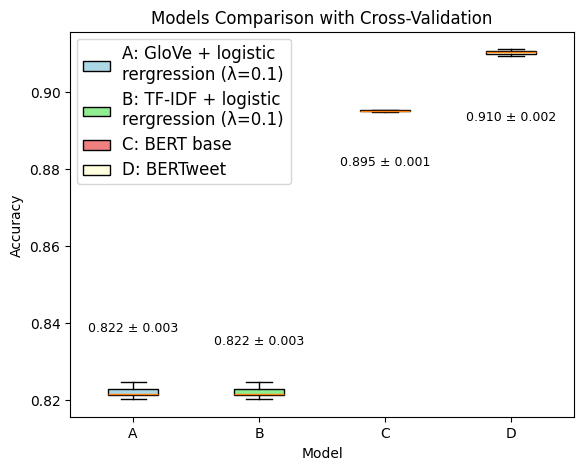

In [6]:
"""PLOTTING THE BOX PLOTS"""

# Create a box plot of the F1 scores
plt.figure(figsize=(6.5, 5))  # Increased the figure width

# Glove  # TEMPORARY
accuracy_1 = np.array([0.82145036, 0.82273435, 0.824584  , 0.82013   , 0.821274  ]),


# TF-IDF  
accuracy_2 = np.array([0.82145036, 0.82273435, 0.824584  , 0.82013   , 0.821274  ]),
# accuracy_2 = cross_val_tfidf

# BERT # TRY WITHOUT DROPPING!!!!!
accuracy_3 = np.array([0.895053259545868, 0.8953329354741388, 0.8950642704091857, 0.8946612728117561, 0.895387759416511]),
# accuracy_3 = cross_val_BERT

# BERTweet # TRY WITHOUT DROPPING!!!!!
accuracy_4 = np.array([0.9110960873998287, 0.9094290426935214, 0.9110784700185203])#0.9190844444444445,0.9188088888888889,0.916232, 0.919104,0.919592])
# accuracy_4 = cross_val_BERTweet



# Create boxplots for each step
box1 = plt.boxplot(accuracy_1, positions=[1], notch=False, patch_artist=True, widths=0.4, whis=2)  # Set whis to 2
box2 = plt.boxplot(accuracy_2, positions=[2], notch=False, patch_artist=True, widths=0.4, whis=2)
box3 = plt.boxplot(accuracy_3, positions=[3], notch=False, patch_artist=True, widths=0.4, whis=2)
box4 = plt.boxplot(accuracy_4, positions=[4], notch=False, patch_artist=True, widths=0.4, whis=2)

# Set colors for the boxes
# colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']

# Set colors for the boxes
# colors = ['mediumseagreen', 'lightcoral', 'cornflowerblue', 'palegoldenrod', 'thistle']

for box, color in zip([box1, box2, box3, box4], colors):
    for patch in box['boxes']:
        patch.set_facecolor(color)

tit = plt.title('Models Comparison with Cross-Validation')
# tit.set_position((0.1,0))
plt.xlabel('Model')
plt.ylabel('Accuracy')

# Calculate and add the mean values to the box plots
mean_values = [np.mean(accuracy_1), np.mean(accuracy_2), np.mean(accuracy_3), np.mean(accuracy_4)]
std_values = [np.std(accuracy_1), np.std(accuracy_2), np.std(accuracy_3), np.std(accuracy_4)]


for i, (mean, std) in enumerate(zip(mean_values, std_values)):
    if i == 0:
        plt.text(i + 1, mean + 0.015, f"{mean:.3f} ± {2*std:.3f}", ha='center', va='bottom', fontsize=9)
    elif i == 1:
        plt.text(i + 1, mean + 0.015, f"{mean:.3f} ± {2*std:.3f}", ha='center', va='top', fontsize=9)
    elif i == 2:
        plt.text(i + 1, mean - 0.015, f"{mean:.3f} ± {2*std:.3f}", ha='center', va='bottom', fontsize=9)
    elif i == 3:
        plt.text(i + 1, mean - 0.015, f"{mean:.3f} ± {2*std:.3f}", ha='center', va='top', fontsize=9)
    elif i == 4:
        plt.text(i + 1, mean - 0.015, f"{mean:.3f} ± {2*std:.3f}", ha='center', va='bottom', fontsize=9)


# Create a custom legend
legend_boxes = [box1["boxes"][0], box2["boxes"][0], box3["boxes"][0], box4["boxes"][0]]
legend = plt.legend(legend_boxes, ['A: GloVe + logistic \nrergression (λ=0.1)', 'B: TF-IDF + logistic \nrergression (λ=0.1)', 'C: BERT base', 'D: BERTweet','E: Ensembling with \nBERTweet'])
legend.get_texts()[0].set_fontsize(12)
legend.get_texts()[1].set_fontsize(12)
legend.get_texts()[2].set_fontsize(12)
legend.get_texts()[3].set_fontsize(12)


# Set the x-axis ticks and labels
plt.xticks([1, 2, 3, 4], ['A', 'B', 'C', 'D'])

plt.show()

## Attention Map

### Load Model

In [3]:
checkpoint = 'vinai/bertweet-base'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Path of weights of 3 Best models
weights_1_file_path = 'weights/best_model_weights_1.pt'
weights_2_file_path = 'weights/best_model_weights_2.pt'
weights_3_file_path = 'weights/best_model_weights_3.pt'

model_classfier_1, model_classfier_2, model_classfier_3 = loadModel(checkpoint,device,\
                                                                    weights_1_file_path,weights_2_file_path,\
                                                                        weights_3_file_path)

## Plot Attention Map

In [37]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenizer.model_max_len=128


tweet = 'you too dudert <user> good morning yall, and have a splendid day'

# Tokenize Tweet
tokenized_tweet = tokenizer(tweet, truncation=True, max_length=128, return_tensors="pt",return_token_type_ids=False)
tokenized_tweetken = tokenized_tweet.to(device)

# Convert token IDs back to words
decoded_tokens = tokenizer.convert_ids_to_tokens(tokenized_tweet['input_ids'][0].tolist(),skip_special_tokens = False )

# Replace <s> by [CLS]
decoded_tokens = ['[CLS]' if token == '<s>' else token for token in decoded_tokens]

# Replace </s> by [SEP]
decoded_tokens = ['[SEP]' if token == '</s>' else token for token in decoded_tokens]


# Use First Best Model to plot Attention Map
# with torch.no_grad():
outputs, pure_loss = model_classfier_1(**tokenized_tweet)
attention = outputs.attentions

# # Plot Mean Attention
mean_attention = torch.stack(attention).mean(dim=0).cpu().detach().numpy().mean(axis=0).mean(axis=0)
mean_attention_clipped = np.clip(mean_attention,0,0.15)



# Plot attention
fig_attention = px.imshow(mean_attention_clipped,labels=dict(x="Key", y="Query"))

# Add xticks and yticks
fig_attention.update_xaxes(tickvals=list(range(len(decoded_tokens))), ticktext=decoded_tokens, title_text="Key")
fig_attention.update_yaxes(tickvals=list(range(len(decoded_tokens))), ticktext=decoded_tokens, title_text="Query")

fig_attention.show()

In [38]:
mean_attention = torch.stack(attention).mean(dim=0).cpu().detach().numpy().mean(axis=0).mean(axis=0)
mean_attention_clipped = np.clip(mean_attention,0,0.65)

# Plot attention
fig_attention = px.imshow(mean_attention_clipped[:,0].reshape(len(mean_attention_clipped),1).T)#,labels=dict(x="Key", y="Query"))

# Add xticks and yticks
fig_attention.update_xaxes(tickvals=list(range(len(decoded_tokens))), ticktext=decoded_tokens, title_text="Key")
fig_attention.update_yaxes(tickvals=list(range(len(decoded_tokens[0]))), ticktext=[decoded_tokens[0]], title_text="Query")

fig_attention.show()

## PCA of [CLS] token outputs

In [55]:
df_sample = df.sample(frac=0.01).reset_index(drop=True)
df_normalized = normalizeTweets(df_sample)


dataset_ = Dataset.from_pandas(df_normalized)

dataset_hf = DatasetDict({
    'test': dataset_})

dataset_hf;


tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenizer.model_max_len=128
def tokenize(batch):
    return tokenizer(batch["tweets"], truncation=True, max_length=128)
tokenized_dataset = dataset_hf.map(tokenize, batched=True)

tokenized_dataset.set_format('torch', columns=["input_ids", "labels"] )

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

test_dataloader = DataLoader(tokenized_dataset['test'], shuffle =False, batch_size = 16, collate_fn = data_collator)


Map: 100%|██████████| 25000/25000 [00:07<00:00, 3376.94 examples/s]


In [56]:
class DataPoint:
    def __init__(self, cls_token, real_label, predicted_label,word_list):
        self.cls_token = cls_token
        self.real_label = real_label
        self.predicted_label = predicted_label

model_classfier_1.eval()


# Create a list to store instances of DataPoint
data_points = []

for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}

    with torch.no_grad():
        outputs, pure_loss = model_classfier_1(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

    real_labels = batch['labels']

    # Iterate over each sequence in the batch
    for i in range(len(predictions)):
        # Extract the CLS token representation
        hidden_states = outputs.hidden_states
        last_layer_hidden_states = hidden_states[-1]
        cls_token = last_layer_hidden_states[i, 0, :]
        word_list = tokenizer.convert_ids_to_tokens(batch['input_ids'][i].tolist())

        # Create an instance of DataPoint and store the information
        data_point = DataPoint(
            cls_token=cls_token,
            real_label=real_labels[i].item(),
            predicted_label=predictions[i].item(),
            word_list=word_list,
        )

        # Append the instance to the list
        data_points.append(data_point)


### Perform PCA

In [57]:
cls_tokens = [data_point.cls_token.cpu().numpy() for data_point in data_points]
real_labels = [data_point.predicted_label for data_point in data_points]

# Mapping dictionary for converting predictions to string labels
label_mapping = {
    0: 'Negative',
    1: 'Positive'
}

# Convert real labels to string labels for legend
legend_labels = [label_mapping[label] for label in set(real_labels)]

# Concatenate the CLS tokens into a single numpy array
cls_tokens_array = np.vstack(cls_tokens)

# Perform PCA to reduce to 2 dimensions
pca = PCA(n_components=3)
pca_result = pca.fit_transform(cls_tokens_array)


### Plot

In [59]:
# Create a DataFrame for the 3D scatter plot
df_plot = pd.DataFrame({
    'PC1': pca_result[:, 0],
    'PC2': pca_result[:, 1],
    'PC3': pca_result[:, 2],
    'Real Label': [label_mapping[label] for label in real_labels]
})

# Create 3D scatter plot using Plotly
fig = px.scatter_3d(
    df_plot,
    x='PC1',
    y='PC2',
    z='PC3',
    color='Real Label',
    labels={'Real Label': 'Sentiment'},
    title='3D PCA of Classification Token of Testing Tweets'
)

# Show the plot
fig.show()
